### Imports

In [1]:
%pip install yfinance
%pip install matplotlib
%pip install scikit-learn
%pip install lxml

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 76.3 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 94.1 MB/s  0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15636 sha256=6f9732c15e4eae8f458eb98541a21776a4e83113ebd88daad47dfa5d8d701f33
  Stored in directory: /home/onyxia/.cache/pip/wheels/1e/df/0f/e2bbb22d689b30c681feb5410ab64a2523437b34c8ecfc6476
  Created wheel for peewee: filename=peewee-3.18.3-cp313-cp313-linux_x86_64.whl size=1044952 sha256=f9f47a4c5b593598ba0b3fa55d638b211d0277da32e88490dc8b52a892c4a433
  Stored in directory: /home/onyxia/.cache/pip/wheels/8c/a9/a4/df972cd49f865ffde174d9c5b26f14f08f8a363ed31e10ff91
Successfully built multi

In [1]:
import pandas as pd
import numpy as np
import pickle
import requests
import copy
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression

## Data collection

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}
html = requests.get(url, headers=headers)
SPY_tickers = pd.read_html(html.text)[0]['Symbol'].tolist()
SPY_tickers.append("^GSPC")

/tmp/ipykernel_4929/801941168.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  SPY_tickers = pd.read_html(html.text)[0]['Symbol'].tolist()


In [4]:
data = yf.download(SPY_tickers, start="2000-01-01", end="2025-11-25", auto_adjust=True)

[*********************100%***********************]  504 of 504 completed

2 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2000-01-01 -> 2025-11-25)')


In [5]:
data.to_parquet("data/SPY_data.pq")

## Dataset creation

In [38]:
data = pd.read_parquet("data/SPY_data.pq")

In [39]:
selected_stocks = data['Close'].columns.unique()[(data['Close'].isna().mean()<0.1)]

In [40]:
len(selected_stocks)

370

In [41]:
data.columns.get_level_values(0).unique()

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [42]:
log_close = np.log(data['Close'])
log_open  = np.log(data['Open'])
log_high  = np.log(data['High'])
log_low   = np.log(data['Low'])

stocks = selected_stocks[:-1]
index = '^GSPC'

# --- returns ---
close_diff = log_close[stocks].diff()
index_ret  = log_close[index].diff()

df = close_diff.mul(1e4).stack().rename("close_1d_ret").reset_index()

df["close_1d_ret_hedged"] = (
    (close_diff.sub(index_ret, axis=0) * 1e4)
    .stack()
    .values
)

# --- open-close ---
open_close = (log_close[stocks] - log_open[stocks]) * 1e4
open_close_idx = (log_close[index] - log_open[index]) * 1e4

df = df.merge(
    open_close.stack().rename("open_close_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (open_close.sub(open_close_idx, axis=0))
        .stack()
        .rename("open_close_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- close-open ---

close_open = (log_open[stocks] - log_close[stocks].shift()) * 1e4
close_open_idx = (log_open[index] - log_close[index].shift()) * 1e4

df = df.merge(
    close_open.stack().rename("close_open_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (close_open.sub(close_open_idx, axis=0))
        .stack()
        .rename("close_open_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- high-low ---
high_low = (log_high[stocks] - log_low[stocks]) * 1e4
high_low_idx = (log_high[index] - log_low[index]) * 1e4

df = df.merge(
    high_low.stack().rename("high_low_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (high_low.sub(high_low_idx, axis=0))
        .stack()
        .rename("high_low_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- volumes ---
volume = data['Volume'][stocks]
dollar_volume = volume * (data['Open'][stocks] + data['Close'][stocks])/2
dolar_volume_share = volume.div(volume.sum(axis=1), axis=0)

df = df.merge(
    volume.stack().rename("volume").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    dollar_volume.stack().rename("dollar_volume").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    dolar_volume_share.stack().rename("share_dollar_volume").reset_index(),
    on=["Date", "Ticker"]
)

In [43]:
df['body_ratio'] = df['open_close_ret'] / (df['high_low_ret']+1e-8)

In [44]:
df['turnover_proxy'] = df['dollar_volume'] / df.groupby('Date')['dollar_volume'].transform('mean')

In [45]:
df.set_index('Date', inplace=True)

In [46]:
df['close_1d_ret_lag1'] = df.groupby('Ticker')['close_1d_ret'].shift()
df['close_1d_ret_hedged_lag1'] = df.groupby('Ticker')['close_1d_ret_hedged'].shift()
df['open_close_ret'] = df.groupby('Ticker')['open_close_ret'].shift()
df['open_close_ret_hedged'] = df.groupby('Ticker')['open_close_ret_hedged'].shift()
df['close_open_ret'] = df.groupby('Ticker')['close_open_ret'].shift()
df['close_open_ret_hedged'] = df.groupby('Ticker')['close_open_ret_hedged'].shift()
df['high_low_ret'] = df.groupby('Ticker')['high_low_ret'].shift()
df['high_low_ret_hedged'] = df.groupby('Ticker')['high_low_ret_hedged'].shift()
df['share_dollar_volume'] = df.groupby('Ticker')['share_dollar_volume'].shift()
df['body_ratio'] = df.groupby('Ticker')['body_ratio'].shift()
df['turnover_proxy'] = df.groupby('Ticker')['turnover_proxy'].shift()

In [47]:
df.tail()

,Ticker,close_1d_ret,close_1d_ret_hedged,open_close_ret,open_close_ret_hedged,close_open_ret,close_open_ret_hedged,high_low_ret,high_low_ret_hedged,volume,dollar_volume,share_dollar_volume,body_ratio,turnover_proxy,close_1d_ret_lag1,close_1d_ret_hedged_lag1
Date,,,,,,,,,,,,,,,,
2025-11-24,XEL,73.783110,-79.705079,1.254567,-70.515747,21.364230,-4.616487,131.688495,-77.893140,6340300.0,5.071289e+08,0.001345,0.009527,0.312582,22.618797,-75.132233
2025-11-24,XOM,-95.259300,-248.747489,7.690347,-64.079967,-2.563889,-28.544605,148.481099,-61.100537,18034900.0,2.102599e+09,0.005508,0.051793,1.880975,5.126458,-92.624573
2025-11-24,YUM,-124.977450,-278.465639,205.389469,133.619155,44.135145,18.154428,232.154747,22.573111,3656900.0,5.535747e+08,0.000868,0.884709,0.381600,249.524614,151.773584
2025-11-24,ZBH,144.320907,-9.167282,297.280165,225.509851,45.926001,19.945284,398.187759,188.606124,2779100.0,2.594290e+08,0.000897,0.746583,0.237808,343.206166,245.455135
2025-11-24,ZBRA,62.060605,-91.427584,370.765291,298.994977,164.144503,138.163786,552.874732,343.293096,930100.0,2.251958e+08,0.000401,0.670614,0.277032,534.909794,437.158763


In [48]:
linear_features = ['close_1d_ret_lag1', 'close_1d_ret_hedged_lag1', 'open_close_ret', 'open_close_ret_hedged', 'close_open_ret', 'close_open_ret_hedged', 'high_low_ret', 'high_low_ret_hedged', 'body_ratio']
non_linear_features = ['share_dollar_volume', 'turnover_proxy']

In [49]:
df

,Ticker,close_1d_ret,close_1d_ret_hedged,open_close_ret,open_close_ret_hedged,close_open_ret,close_open_ret_hedged,high_low_ret,high_low_ret_hedged,volume,dollar_volume,share_dollar_volume,body_ratio,turnover_proxy,close_1d_ret_lag1,close_1d_ret_hedged_lag1
Date,,,,,,,,,,,,,,,,
2000-01-04,A,-794.643144,-403.651390,NaN,NaN,NaN,NaN,NaN,NaN,4765083.0,1.920636e+08,NaN,NaN,NaN,NaN,NaN
2000-01-04,AAPL,-880.772906,-489.781152,NaN,NaN,NaN,NaN,NaN,NaN,512377600.0,4.048176e+08,NaN,NaN,NaN,NaN,NaN
2000-01-04,ABT,-289.878800,101.112954,NaN,NaN,NaN,NaN,NaN,NaN,10734887.0,8.536905e+07,NaN,NaN,NaN,NaN,NaN
2000-01-04,ACGL,-54.500128,336.491626,NaN,NaN,NaN,NaN,NaN,NaN,84600.0,1.019541e+05,NaN,NaN,NaN,NaN,NaN
2000-01-04,ADBE,-876.182492,-485.190739,NaN,NaN,NaN,NaN,NaN,NaN,7813200.0,1.193387e+08,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-24,XEL,73.783110,-79.705079,1.254567,-70.515747,21.364230,-4.616487,131.688495,-77.893140,6340300.0,5.071289e+08,0.001345,0.009527,0.312582,22.618797,-75.132233
2025-11-24,XOM,-95.259300,-248.747489,7.690347,-64.079967,-2.563889,-28.544605,148.481099,-61.100537,18034900.0,2.102599e+09,0.005508,0.051793,1.880975,5.126458,-92.624573
2025-11-24,YUM,-124.977450,-278.465639,205.389469,133.619155,44.135145,18.154428,232.154747,22.573111,3656900.0,5.535747e+08,0.000868,0.884709,0.381600,249.524614,151.773584


# Feature list
1. Avg past returns close to close
2. Avg past returns open to close
3. Avg past returns low to close
4. Avg past returns high to low

- Hedged/Not hedged
- Clipped/Not clipped

# Models list

## Baseline
1. Random
2. Past returns (define period)
3. MACD vol adjusted
4. Linear Regression (define features + beta)

## LTR
1. LambdaMART (pairwise)
2. LambdaRANK (listwise)
3. ListMLE (listwise - use LightGBM)

# Baseline models

## Random Strategy

In [18]:
np.random.seed(42)
df['random_signal'] = 0.0

def assign_random_signals(group):
    n = len(group)
    if n >= 70:
        signals = np.array([1.0] * 35 + [-1.0] * 35 + [0.0] * (n - 70))
        np.random.shuffle(signals)
        return pd.Series(signals, index=group.index)
    else:
        return pd.Series(0.0, index=group.index)

df['random_signal'] = df.groupby('Date', group_keys=False).apply(assign_random_signals)

In [19]:
random_daily_returns = df.groupby('Date').apply(lambda x: (x['random_signal']*x['close_1d_ret']).mean())

<Axes: title={'center': 'Cumulative Random Strategy Return'}, xlabel='Date'>

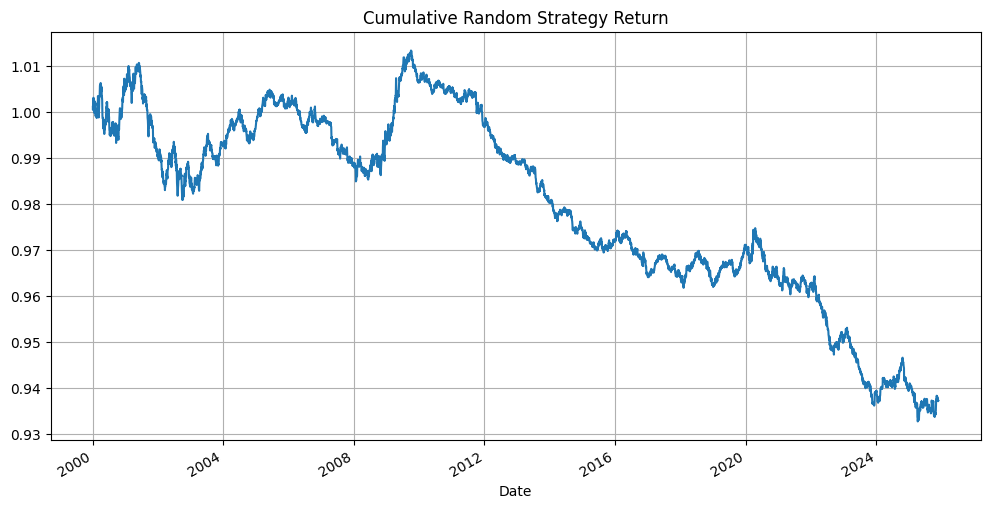

In [20]:
(random_daily_returns.cumsum()*1e-4+1).plot(figsize=(12,6), title='Cumulative Random Strategy Return', grid=True)

In [21]:
random_daily_returns.mean()/random_daily_returns.std()*np.sqrt(252)

np.float64(-0.34995906579976316)

## Momentum Strategies

### Simple Momentum Strategy

In [22]:
def compute_signal(x):
    if x.notna().sum() == 0:
        return pd.Series([np.nan]*len(x), index=x.index)
    ranks = x.rank(method='first')
    binned = pd.cut(ranks, bins=10, labels=False, include_lowest=True)
    signal = binned.map(lambda y: 1 if y == 0 else (-1 if y == 9 else 0))
    return signal

In [23]:
df['momentum_hedged_signal'] = df.groupby('Date')['close_1d_ret_hedged'].transform(compute_signal)

In [24]:
df['momentum_hedged_signal'] = df.groupby('Ticker')['momentum_hedged_signal'].shift()

In [25]:
df['momentum_signal'] = df.groupby('Date')['close_1d_ret'].transform(compute_signal)

In [26]:
df['momentum_signal'] = df.groupby('Ticker')['momentum_signal'].shift()

In [27]:
momentum_daily_returns = df.groupby('Date').apply(
    lambda x: pd.Series({
        'hedged': (x['momentum_hedged_signal'] * x['close_1d_ret']).mean(),
        'unhedged': (x['momentum_signal'] * x['close_1d_ret']).mean()
    })
)*1e-4

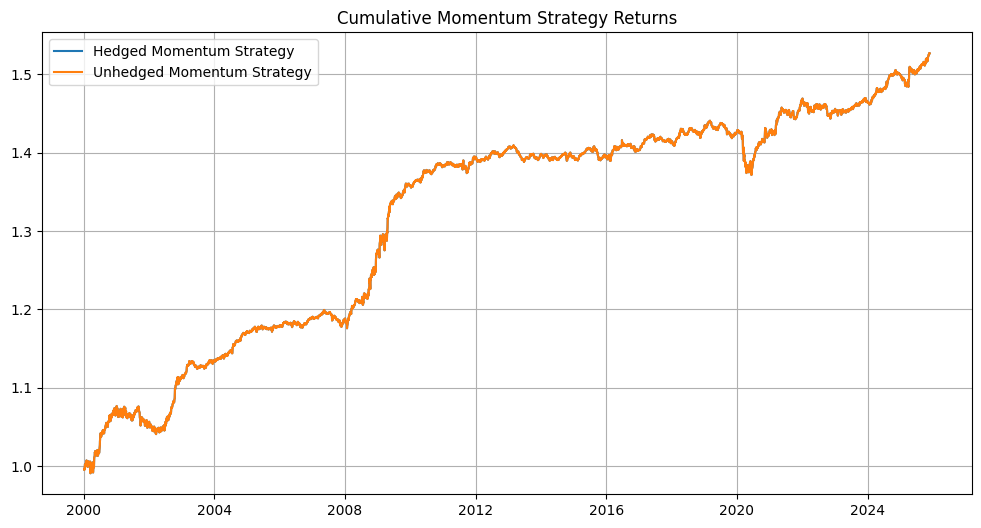

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(momentum_daily_returns['hedged'].cumsum() + 1, label='Hedged Momentum Strategy')
plt.plot(momentum_daily_returns['unhedged'].cumsum() + 1, label='Unhedged Momentum Strategy')

plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [29]:
momentum_daily_returns.mean()/momentum_daily_returns.std()*np.sqrt(252)

hedged      0.977783
unhedged    0.977783
dtype: float64

### MACD Vol adjusted Strategy

In [30]:
def compute_signal(x):
    if x.notna().sum() == 0:
        return pd.Series([np.nan]*len(x), index=x.index)
    ranks = x.rank(method='first')
    binned = pd.cut(ranks, bins=10, labels=False, include_lowest=True)
    signal = binned.map(lambda y: 1 if y == 0 else (-1 if y == 9 else 0))
    return signal

In [31]:
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]

In [32]:
for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
    macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
    macd_adj_series.name = f'macd_adj_{i+1}'
    df = df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
    df[f'macd_adj_{i+1}'] /= df[f'macd_adj_{i+1}'].rolling(252).std()

In [33]:
def phi_baz(x):
    return x / np.sqrt(1 + x**2)

In [34]:
df['macd_baz_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(phi_baz).sum(1).replace(0, np.nan)
df['macd_baz_signal'] = df.groupby('Date')['macd_baz_signal'].transform(compute_signal)

In [35]:
df['macd_tanh_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(np.tanh).sum(1).replace(0, np.nan)
df['macd_tanh_signal']  = df.groupby('Date')['macd_tanh_signal'].transform(compute_signal)

In [36]:
df['macd_baz_signal'] = df.groupby('Ticker')['macd_baz_signal'].shift()
df['macd_tanh_signal'] = df.groupby('Ticker')['macd_tanh_signal'].shift()

In [37]:
macd_daily_returns = df.groupby('Date').apply(
    lambda x: pd.Series({
        'baz': (x['macd_baz_signal'] * x['close_1d_ret']).mean(),
        'tanh': (x['macd_tanh_signal'] * x['close_1d_ret']).mean()
    })
)*1e-4

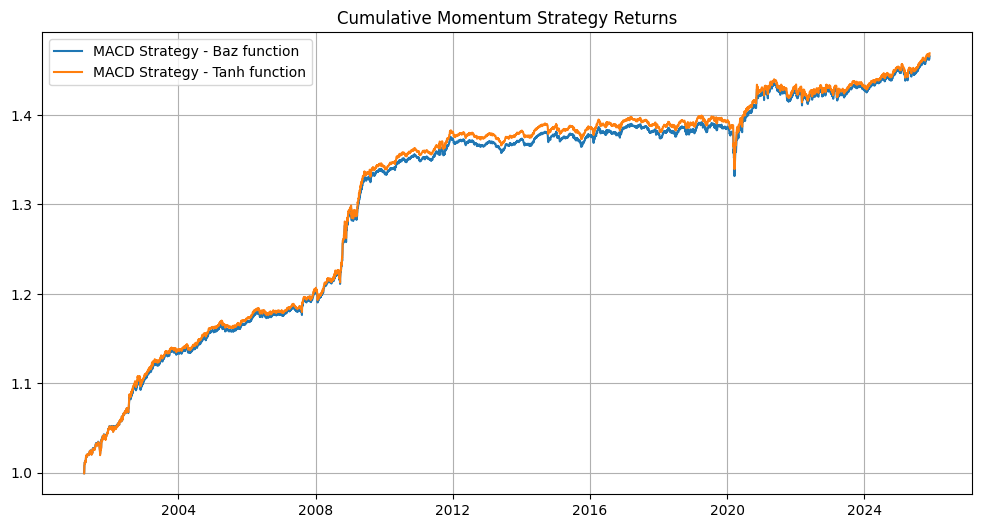

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(macd_daily_returns['baz'].cumsum() + 1, label='MACD Strategy - Baz function')
plt.plot(macd_daily_returns['tanh'].cumsum() + 1, label='MACD Strategy - Tanh function')

plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [39]:
macd_daily_returns.mean()/macd_daily_returns.std()*np.sqrt(252)

baz     1.114831
tanh    1.122410
dtype: float64

# Regress-then-rank Strategies 

## Linear Regression

### Feature factory

In [34]:
def daily_metrics(group, feature, target, beta_global):
    reg = LinearRegression(fit_intercept=False)
    if len(group) < 2:
        return pd.Series({'beta': np.nan, 'bias': np.nan})
    reg.fit(group[[feature]], group[target])
    predictions = reg.predict(group[[feature]])
    bias = np.std(predictions)
    if reg.coef_[0]*beta_global < 0:
        bias *= -1
    return pd.Series({'bias': bias})

In [ ]:
def single_feature_metrics(df, feature, target, drop_extreme_perc=True, ts_bool=False, fit_intercept=False):
    global_reg = LinearRegression(fit_intercept=fit_intercept)
    if drop_extreme_perc:
        first_perc, last_perc = np.percentile(df[feature].dropna(), [1, 99])
        df_filtered = df[(df[feature]>=first_perc) & (df[feature]<=last_perc)]
    else:
        df_filtered = df.copy(deep=True)
    global_reg.fit(df_filtered[[feature]], df_filtered[target])
    predictions = global_reg.predict(df_filtered[[feature]])
    bias = np.std(predictions)
    stab = (predictions * df_filtered[target] > 0).mean() * 100
    beta_global = global_reg.coef_[0]
    if ts_bool:
        bias_ts = df_filtered.groupby('Date').apply(lambda x: daily_metrics(x, feature, target, beta_global))
        mean_bias_ts = bias_ts['bias'].mean()
        sharpe_ts = bias_ts['bias'].mean() / bias_ts['bias'].std() * np.sqrt(252)
        return bias, mean_bias_ts, stab, beta_global, sharpe_ts, bias_ts
    else:
        return bias, stab, beta_global

In [50]:
linear_features

['close_1d_ret_lag1',
 'close_1d_ret_hedged_lag1',
 'open_close_ret',
 'open_close_ret_hedged',
 'close_open_ret',
 'close_open_ret_hedged',
 'high_low_ret',
 'high_low_ret_hedged',
 'body_ratio']

In [51]:
all_linear_features = copy.deepcopy(linear_features)

In [ ]:
for feature in linear_features:
    print(feature)
    plt.hist(pd.Series(winsorize(df[feature], limits=0.001)).dropna(), bins=100)
    plt.title(f'{feature} hist')
    plt.show()

In [52]:
for feature in tqdm(linear_features):
    for h in [3, 5, 10, 15, 20, 30, 60, 80]:
        df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
        df[f'zscore_{feature}_{h}d'] = (df[feature]-df[f'avg_{feature}_{h}d'])/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
        df[f'sharpe_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
        all_linear_features.append(f'avg_{feature}_{h}d')
        all_linear_features.append(f'zscore_{feature}_{h}d')
        all_linear_features.append(f'sharpe_{feature}_{h}d')

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:45<01:32, 15.37s/it]/tmp/ipykernel_11572/3641886625.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'sharpe_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
/tmp/ipykernel_11572/3641886625.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
/tmp/ipykernel_11572/3641886625.py:4: PerformanceWarning: DataFrame is highly fragmented.  This

In [ ]:
df.to_parquet('df.pq')

In [53]:
for feature in tqdm(all_linear_features):
    df[feature] = winsorize(df[feature], limits=0.001)

100%|██████████| 225/225 [01:27<00:00,  2.58it/s]


In [ ]:
# for feature in linear_features:
#     print(feature)
#     plt.hist(df[feature].replace([-np.inf, np.inf], np.nan), bins=100)
#     plt.title(f'{feature} hist')
#     plt.show()
#     for feature_type in ['avg', 'zscore', 'sharpe']:
#         for window in [5, 30, 80]:
#             temp_feature = f'{feature_type}_{feature}_{window}d'
#             plt.hist(df[temp_feature].replace([-np.inf, np.inf], np.nan), bins=100)
#             plt.title(f'{temp_feature} hist')
#             plt.show()

In [ ]:
dict_results = {'feature': [], 'bias': [], 'mean_bias_ts': [], 'stability': [], 'beta': [], 'sharpe_ts': [], 'bias_ts': []}
for feature in tqdm(all_linear_features):
    bias, mean_bias_ts, stability, beta, sharpe_ts, bias_ts = single_feature_metrics(df[[feature, 'close_1d_ret']].dropna(), feature, 'close_1d_ret', drop_extreme_perc=False,  ts_bool=True)
    dict_results['feature'].append(feature)
    dict_results['bias'].append(bias)
    dict_results['mean_bias_ts'].append(mean_bias_ts)
    dict_results['stability'].append(stability)
    dict_results['beta'].append(beta)
    dict_results['sharpe_ts'].append(sharpe_ts)
    dict_results['bias_ts'].append(bias_ts)

In [ ]:
# with open("dict_results.pkl", "wb") as f:
#     pickle.dump(dict_results, f)

with open("dict_results.pkl", "rb") as f:
    dict_results = pickle.load(f)

In [ ]:
results_df = pd.DataFrame(dict_results).set_index('feature')
results_df['feature_type'] = pd.Series(results_df.index.str.split('_')).apply(lambda x: x[0] if x[0] in ['avg', 'zscore', 'sharpe'] else 'spot').values
results_df['window'] = pd.Series(results_df.index.str.split('_')).apply(lambda x: int(x[-1][:-1]) if (x[-1][-1]=='d' and x[-1]!='hedged') else 1).values
results_df['feature_name'] = np.where(results_df['feature_type']!='spot', pd.Series(results_df.index.str.split('_')).apply(lambda x: '_'.join(x[1:-1])), results_df.index)

In [ ]:
linear_features

In [ ]:
results_df.sort_values('mean_bias_ts').tail(50)

In [ ]:
results_df.loc['zscore_open_close_ret_60d', 'bias_ts'].cumsum().plot()

### Article features

In [14]:
article_features = []

feature = 'close_1d_ret'
for h in [3, 5, 20, 60]:
    df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
    df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[f'avg_{feature}_{h}d'].shift()
    df[f'vol_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())*np.sqrt(252)
    df[f'vol_{h}d'] = df.groupby('Ticker')[f'vol_{h}d'].shift()
    df[f'avg_normalised_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df[f'vol_{h}d']
    article_features.append(f'avg_{feature}_{h}d')
    article_features.append(f'avg_normalised_{feature}_{h}d')

#### Test for MACD Features

In [41]:
test_df = df[['Ticker']]
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]
for window in tqdm([21, 63, 126, 252]):
    for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
        macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
        macd_adj_series.name = f'macd_adj_first_{window}_{i+1}'
        test_df = test_df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
        test_df[f'macd_adj_first_{window}_{i+1}'] /= test_df[f'macd_adj_first_{window}_{i+1}'].rolling(window).std()

for window in tqdm([21, 63, 126, 252]):
    for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
        macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(window).std()
        macd_adj_series.name = f'macd_adj_second_{window}_{i+1}'
        test_df = test_df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
        test_df[f'macd_adj_second_{window}_{i+1}'] /= test_df[f'macd_adj_second_{window}_{i+1}'].rolling(252).std()

100%|██████████| 4/4 [00:32<00:00,  8.01s/it]


In [42]:
test_df.drop(columns='Ticker').corr()

,macd_adj_first_21_1,macd_adj_first_21_2,macd_adj_first_21_3,macd_adj_first_63_1,macd_adj_first_63_2,macd_adj_first_63_3,macd_adj_first_126_1,macd_adj_first_126_2,macd_adj_first_126_3,macd_adj_first_252_1,...,macd_adj_second_21_3,macd_adj_second_63_1,macd_adj_second_63_2,macd_adj_second_63_3,macd_adj_second_126_1,macd_adj_second_126_2,macd_adj_second_126_3,macd_adj_second_252_1,macd_adj_second_252_2,macd_adj_second_252_3
macd_adj_first_21_1,1.000000,0.862448,0.544222,0.960550,0.848635,0.596267,0.951997,0.837783,0.585889,0.949976,...,0.579770,0.949976,0.833573,0.575704,0.928337,0.814925,0.564625,0.911329,0.800540,0.555165
macd_adj_first_21_2,0.862448,1.000000,0.822700,0.821791,0.942424,0.837304,0.814090,0.934597,0.838068,0.812094,...,0.852135,0.812094,0.933049,0.834615,0.793941,0.912427,0.818102,0.779571,0.896405,0.804267
macd_adj_first_21_3,0.544222,0.822700,1.000000,0.526924,0.768294,0.915679,0.523233,0.761163,0.907902,0.521071,...,0.937931,0.521071,0.759594,0.910464,0.509796,0.743146,0.890182,0.500556,0.730411,0.875356
macd_adj_first_63_1,0.960550,0.821791,0.526924,1.000000,0.878665,0.612981,0.987832,0.862525,0.598377,0.984285,...,0.560497,0.984285,0.855684,0.585666,0.953605,0.829396,0.569586,0.934678,0.813598,0.559381
macd_adj_first_63_2,0.848635,0.942424,0.768294,0.878665,1.000000,0.873316,0.868632,0.984113,0.863105,0.865467,...,0.826703,0.865467,0.978482,0.853231,0.839060,0.948841,0.829472,0.822363,0.930568,0.814193
macd_adj_first_63_3,0.596267,0.837304,0.915679,0.612981,0.873316,1.000000,0.608304,0.861981,0.974059,0.605875,...,0.945715,0.605875,0.857235,0.966571,0.587883,0.831937,0.937928,0.576041,0.815984,0.920777
macd_adj_first_126_1,0.951997,0.814090,0.523233,0.987832,0.868632,0.608304,1.000000,0.874801,0.606877,0.994757,...,0.563234,0.994757,0.866435,0.592892,0.977363,0.851635,0.584757,0.953403,0.831473,0.571655
macd_adj_first_126_2,0.837783,0.934597,0.761163,0.862525,0.984113,0.861981,0.874801,1.000000,0.879208,0.870312,...,0.834585,0.870312,0.992613,0.866931,0.855273,0.975333,0.853965,0.834300,0.952048,0.834405
macd_adj_first_126_3,0.585889,0.838068,0.907902,0.598377,0.863105,0.974059,0.606877,0.879208,1.000000,0.603716,...,0.960619,0.603716,0.873339,0.988161,0.593846,0.858495,0.971385,0.579189,0.838055,0.949056
macd_adj_first_252_1,0.949976,0.812094,0.521071,0.984285,0.865467,0.605875,0.994757,0.870312,0.603716,1.000000,...,0.564741,1.000000,0.872006,0.596576,0.988100,0.861958,0.591770,0.970893,0.847576,0.582688


#### End

In [15]:
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]

for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
    macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
    macd_adj_series.name = f'macd_adj_{i+1}'
    df = df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
    df[f'macd_adj_{i+1}'] /= df[f'macd_adj_{i+1}'].rolling(252).std()
    df[f'macd_adj_{i+1}'] = df.groupby('Ticker')[f'macd_adj_{i+1}'].shift()
    article_features.append(f'macd_adj_{i+1}')

In [16]:
def phi_baz(x):
    return x / np.sqrt(1 + x**2)

In [17]:
df['macd_baz_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(phi_baz).sum(1).replace(0, np.nan)
article_features.append('macd_baz_signal')

In [18]:
df[article_features].corr()

,avg_close_1d_ret_3d,avg_normalised_close_1d_ret_3d,avg_close_1d_ret_5d,avg_normalised_close_1d_ret_5d,avg_close_1d_ret_20d,avg_normalised_close_1d_ret_20d,avg_close_1d_ret_60d,avg_normalised_close_1d_ret_60d,macd_adj_1,macd_adj_2,macd_adj_3,macd_baz_signal
avg_close_1d_ret_3d,1.000000,0.091819,0.764323,0.544911,0.382295,0.317011,0.212484,0.190414,0.740697,0.667845,0.539244,0.663946
avg_normalised_close_1d_ret_3d,0.091819,1.000000,0.070112,0.102536,0.034834,0.043934,0.021331,0.026352,0.092973,0.083069,0.066661,0.089137
avg_close_1d_ret_5d,0.764323,0.070112,1.000000,0.711720,0.493262,0.406501,0.273725,0.244150,0.695911,0.729384,0.636553,0.712875
avg_normalised_close_1d_ret_5d,0.544911,0.102536,0.711720,1.000000,0.347252,0.435392,0.205000,0.253542,0.690690,0.720818,0.626549,0.749619
avg_close_1d_ret_20d,0.382295,0.034834,0.493262,0.347252,1.000000,0.811815,0.554119,0.477514,0.186521,0.465766,0.680538,0.466479
avg_normalised_close_1d_ret_20d,0.317011,0.043934,0.406501,0.435392,0.811815,1.000000,0.454960,0.552627,0.213785,0.531584,0.777214,0.547523
avg_close_1d_ret_60d,0.212484,0.021331,0.273725,0.205000,0.554119,0.454960,1.000000,0.840505,0.024768,0.083329,0.285124,0.119466
avg_normalised_close_1d_ret_60d,0.190414,0.026352,0.244150,0.253542,0.477514,0.552627,0.840505,1.000000,0.035787,0.106930,0.343444,0.152474
macd_adj_1,0.740697,0.092973,0.695911,0.690690,0.186521,0.213785,0.024768,0.035787,1.000000,0.872016,0.596609,0.843095
macd_adj_2,0.667845,0.083069,0.729384,0.720818,0.465766,0.531584,0.083329,0.106930,0.872016,1.000000,0.875448,0.953327


In [19]:
df[['Ticker', 'close_1d_ret']+article_features].to_parquet('df_article.pq')

### Ridge regression

In [27]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [21]:
ridge_reg = Ridge(fit_intercept=False)

In [24]:
df = pd.read_parquet('df_article.pq')

In [25]:
df.head()

,Ticker,close_1d_ret,avg_close_1d_ret_3d,avg_normalised_close_1d_ret_3d,avg_close_1d_ret_5d,avg_normalised_close_1d_ret_5d,avg_close_1d_ret_20d,avg_normalised_close_1d_ret_20d,avg_close_1d_ret_60d,avg_normalised_close_1d_ret_60d,macd_adj_1,macd_adj_2,macd_adj_3,macd_baz_signal
Date,,,,,,,,,,,,,,
2000-01-04,A,-794.643144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,A,-640.373387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,A,-388.198152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,A,800.426913,-607.738228,-0.186588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,A,588.126902,-76.048209,-0.006226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
X = df[all_linear_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[all_linear_features]
y = df[all_linear_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

In [28]:
def expanding_cv_score(model, X, y, n_splits=5, lower=0.01, upper=0.01):
    """
    Performs expanding-window CV with winsorization applied to X.
    Winsorization limits are fit on each training window and applied to validation window.
    
    Parameters:
    - model: estimator with fit/predict
    - X: pandas DataFrame
    - y: pandas Series
    - n_splits: number of expanding CV splits
    - lower, upper: winsorization proportions
    """
    n_samples = len(X)
    split_size = (n_samples // 2) // n_splits  # size of each incremental step

    mse_list = []

    for i in tqdm(range(n_splits)):
        train_end = n_samples//2 + split_size * i
        val_end = n_samples//2 + split_size * (i + 1)

        # Slice windows
        X_train_cv = X.iloc[:train_end].copy()
        y_train_cv = y.iloc[:train_end]

        X_val_cv = X.iloc[train_end:val_end].copy()
        y_val_cv = y.iloc[train_end:val_end]

        # ---- Winsorization ----
        # Fit limits on TRAINING data only
        lower_bounds = {}
        upper_bounds = {}

        for col in X.columns:
            lb = np.percentile(X_train_cv[col], lower * 100)
            ub = np.percentile(X_train_cv[col], 100 - upper * 100)

            lower_bounds[col] = lb
            upper_bounds[col] = ub

            # apply to train
            X_train_cv[col] = np.clip(X_train_cv[col], lb, ub)
            # apply SAME limits to val
            X_val_cv[col] = np.clip(X_val_cv[col], lb, ub)

        # Fit + evaluate model
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_val_cv)
        mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))

    return mse_list

In [55]:
X

,close_1d_ret_lag1,close_1d_ret_hedged_lag1,open_close_ret,open_close_ret_hedged,close_open_ret,close_open_ret_hedged,high_low_ret,high_low_ret_hedged,body_ratio,avg_close_1d_ret_lag1_3d,...,sharpe_body_ratio_20d,avg_body_ratio_30d,zscore_body_ratio_30d,sharpe_body_ratio_30d,avg_body_ratio_60d,zscore_body_ratio_60d,sharpe_body_ratio_60d,avg_body_ratio_80d,zscore_body_ratio_80d,sharpe_body_ratio_80d
Date,,,,,,,,,,,,,,,,,,,,,
2000-04-28,-123.208216,-150.072037,180.685598,153.821778,-303.893814,-303.893814,466.476441,229.553065,0.387341,-31.985290,...,-0.046220,-0.010234,0.726163,-0.018692,0.058414,0.562727,0.099934,0.006870,0.662705,0.011966
2000-04-28,438.468903,411.605083,784.410188,757.546367,-345.941285,-345.941285,856.259096,619.335720,0.916090,168.554552,...,0.077718,0.119983,1.266962,0.190948,0.084631,1.429023,0.145455,0.026003,1.558349,0.045525
2000-04-28,0.000000,-26.863820,129.033313,102.169492,-129.033313,-129.033313,193.867129,-43.056248,0.665576,-89.597459,...,0.395823,0.136161,0.937117,0.241019,0.053502,1.103033,0.096417,0.044482,1.142541,0.081827
2000-04-28,218.916976,192.053156,401.663763,374.799943,-182.746787,-182.746787,401.663763,164.740386,1.000000,161.320746,...,-0.093097,0.041742,1.471520,0.064100,0.085414,1.366671,0.127634,0.104484,1.353333,0.157899
2000-04-28,718.903377,692.039556,1214.158954,1106.509386,-611.348540,-611.348540,1514.768814,1277.845438,0.878188,547.194138,...,0.101737,0.143140,1.312491,0.255588,0.137741,1.262530,0.234862,0.084557,1.349377,0.143769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-24,22.618797,-75.132233,1.254567,-70.515747,21.364230,-4.616487,131.688495,-77.893140,0.009527,-55.186914,...,-0.237099,-0.140094,0.373288,-0.349519,-0.034058,0.095404,-0.074550,-0.040705,0.104530,-0.084706
2025-11-24,5.126458,-92.624573,7.690347,-64.079967,-2.563889,-28.544605,148.481099,-61.100537,0.051793,-55.060248,...,0.125646,0.057915,-0.011715,0.110838,0.020481,0.059870,0.039160,0.050425,0.002575,0.094884
2025-11-24,249.524614,151.773584,205.389469,133.619155,44.135145,18.154428,232.154747,22.573111,0.884709,91.898976,...,-0.098969,-0.023307,1.829591,-0.046962,-0.010739,1.746789,-0.020949,0.002788,1.725454,0.005455


In [56]:
y

Date
2000-04-28   -236.942062
2000-04-28   -214.307432
2000-04-28   -145.283196
2000-04-28   -309.872530
2000-04-28   -204.609690
                 ...    
2025-11-24     73.783110
2025-11-24    -95.259300
2025-11-24   -124.977450
2025-11-24    144.320907
2025-11-24     62.060605
Name: close_1d_ret, Length: 2366429, dtype: float64

In [58]:
# ---------------------------
# Hyperparameter tuning
# ---------------------------
alphas = [0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 1000000]
alpha_mse = {}

for a in tqdm(alphas):
    ridge = Pipeline(
        [
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=a, fit_intercept=False))
        ]
    )
    mse = expanding_cv_score(ridge, X_train, y_train, n_splits=5)
    alpha_mse[a] = mse

100%|██████████| 8/8 [15:42<00:00, 117.80s/it]


In [59]:
pd.DataFrame(alpha_mse)

,0.1,0.3,1.0,3.0,10.0,30.0,100.0,1000000.0
0,36851.338449,36851.159987,36850.539184,36848.797384,36843.046075,36829.014620,36796.182187,36582.720488
1,19768.098052,19768.076079,19767.999418,19767.782438,19767.045737,19765.109388,19759.662813,19572.834179
2,27246.176048,27246.160047,27246.104253,27245.946601,27245.414524,27244.044213,27240.482848,27149.184843
3,20474.209778,20474.154166,20473.959831,20473.407188,20471.502445,20466.294185,20450.239665,20023.275526
4,69036.647422,69036.573413,69036.314753,69035.578878,69033.039536,69026.080884,69004.718701,68441.658515


In [57]:
pd.DataFrame(alpha_mse)

,0.1,0.3,1.0,3.0,10.0,30.0,100.0,1000000.0
0,47987.835548,47987.835547,47987.835542,47987.835530,47987.835488,47987.835374,47987.835053,47999.113615
1,44766.820008,44766.819996,44766.819957,44766.819845,44766.819455,44766.818345,44766.814525,44782.940717
2,47514.816276,47514.816273,47514.816265,47514.816239,47514.816152,47514.815904,47514.815074,47527.595993
3,49637.849807,49637.849777,49637.849674,49637.849379,49637.848349,49637.845408,49637.835160,49639.334959
4,53703.832565,53703.832558,53703.832533,53703.832461,53703.832209,53703.831490,53703.829000,53716.449198


<Axes: >

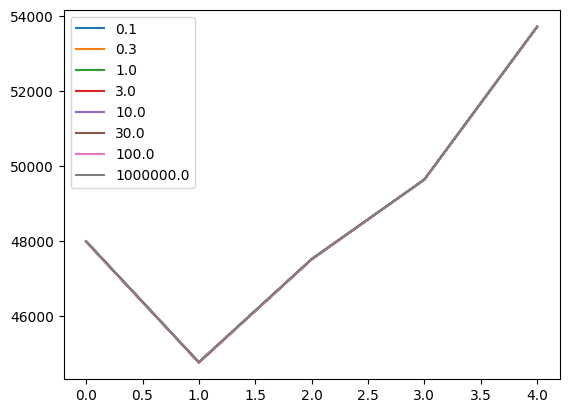

In [33]:
pd.DataFrame(alpha_mse).plot()

In [ ]:
# ---------------------------
# Final model training on full training set
# ---------------------------
ridge_reg = Ridge(alpha=best_alpha, fit_intercept=False)
ridge_reg.fit(X_train, y_train)

y_pred = ridge_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("\nRidge Coefficients:", ridge_reg.coef_)
print("Ridge Intercept:", ridge_reg.intercept_)
print("Test MSE:", mse)

In [ ]:
for h in [3, 5, 10, 20, 50, 100]:
    for clip in [100, 200, 300, 400]:
        df[f'avg_ret_hedged_{h}d_clip{clip}'] = df[f'avg_ret_hedged_{h}d'].clip(-clip, clip)

In [ ]:
plt.figure(figsize=(12, 6))
for h in dict_results['avg_ret_hedged'].keys():
    dict_results['avg_ret_hedged'][h][-1]['bias'].cumsum().plot(label=f'{h} days')
plt.legend()
plt.title('Cumulative Bias Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Bias')
plt.grid(True, alpha=0.3)
plt.show()